사용 모듈

In [186]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# %matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage import io
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [187]:
image_width = 256
image_height = 256

데이터 불러오기

In [188]:
Path="C:\\Project1\\"
train_files = []
mask_files = glob(Path+'lgg-mri-segmentation\\kaggle_3m\\*\\*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'C:\\Project1\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_49

데이터 확인

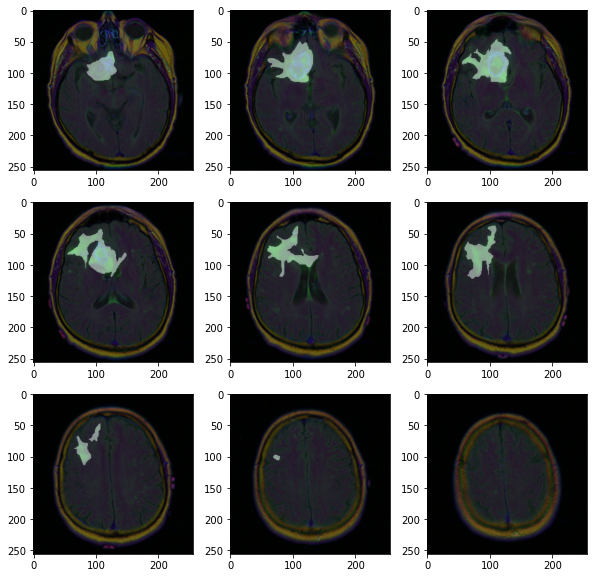

In [189]:
rows, cols = 3,3
fig = plt.figure(figsize=(10,10))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)
    if img is None:
        print('Wrong path:', img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()


196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)
196608 (256, 256, 3) uint8
196608 (256, 256, 3) uint8
65536 (256, 256)


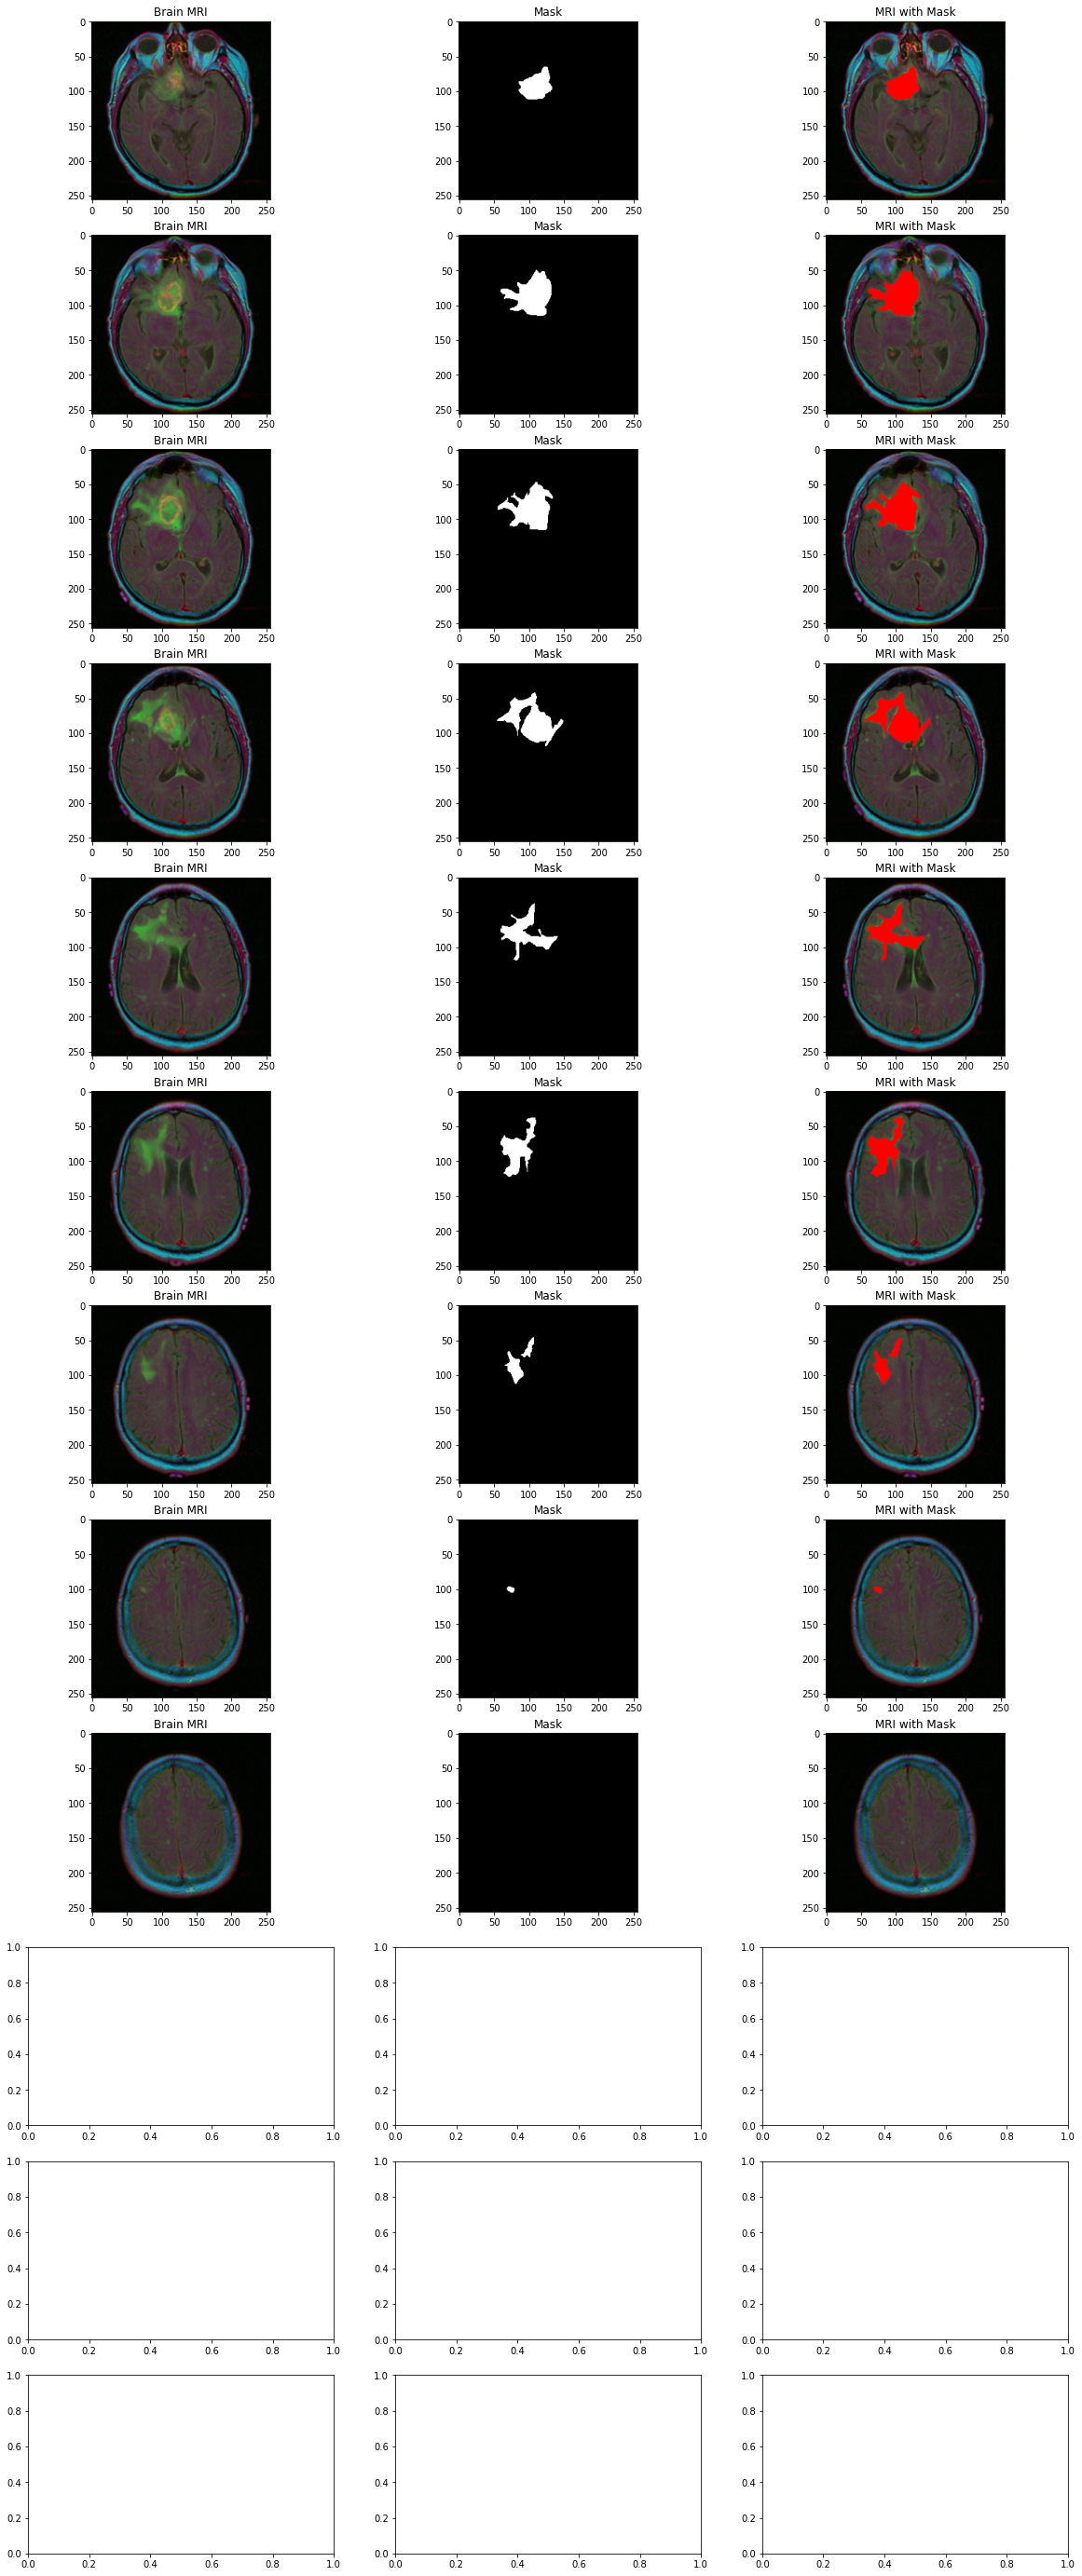

In [190]:
count = 0

from PIL import Image

rows, cols = 3,3
fig,axs = plt.subplots(12,3, figsize=(20,50))
for i in range(1, rows*cols+1):
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)

    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)
    
    msk = cv2.imread(msk_path)
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(msk, cmap='gray')

    msk2 = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

    for y in range(0,256):
        for x in range(0,256):
            if msk2[y, x] > 10:
                msk2[y, x] = 255
    msk2 = cv2.cvtColor(msk2, cv2.COLOR_GRAY2RGB)

    msk2 = cv2.add(img, msk2)
    msk2[np.where((msk2 == [255,255,255]).all(axis = 2))] = [255,0,0]

    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(msk2)
    count +=1


plt.show()

In [191]:
df = pd.DataFrame(data={'filename': train_files, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.1)
df_train, df_val = train_test_split(df_train, test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


Train Image 변형

In [192]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)
        
def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [193]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

Unet model

In [194]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    s = inputs

    """Encoder"""
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    """Decoder""" 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

In [195]:
model = unet()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 256, 256, 16) 0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 2320        dropout_36[0][0]                 
____________________________________________________________________________________________

하이퍼 파라미터

In [196]:
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4

#learning_rate_schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# learning_rate_cosine_schedule
lr_cosine_schedule = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate= 1e-2, 
    first_decay_steps= 100 , 
    t_mul=2.0, 
    m_mul=1.0, 
    alpha=0.0,
    name=None
)

학습 시작

In [199]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(image_height, image_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))

# model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_cosine_schedule)
#              , loss='binary_crossentropy'
#              , metrics=['accuracy'])
callbacks = [ModelCheckpoint('C:\\Users\\82105\\OneDrive\\바탕 화면\\Lee Jucheon\\unet_brain_mri_Unet_Adam.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
 1/88 [..............................] - ETA: 11:38 - loss: 0.6757 - accuracy: 0.6626

Loss 및 Accuraacy 그래프

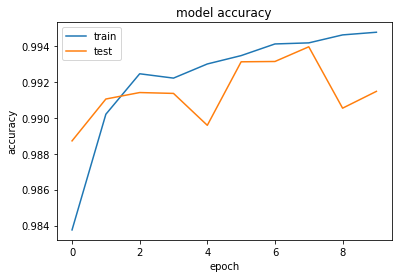

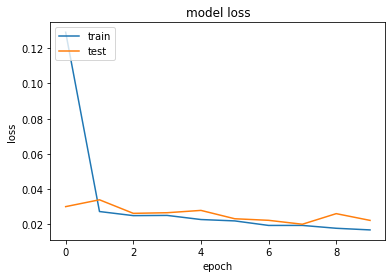

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

결과 도출

In [ ]:
# model = load_model('unet_brain_mri_Unet.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
model = load_model('C:\\Users\\82105\\OneDrive\\바탕 화면\\Lee Jucheon\\unet_brain_mri_Unet_Adam.hdf5')

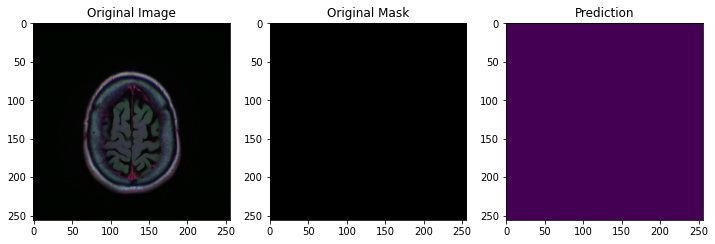

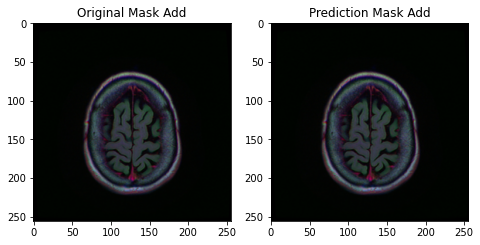

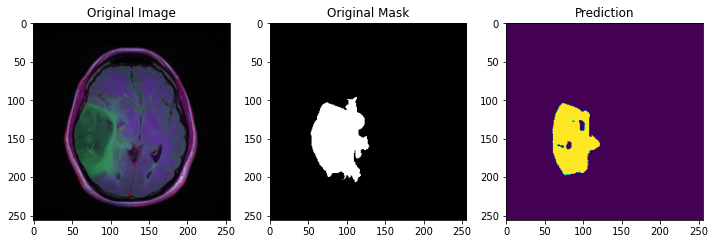

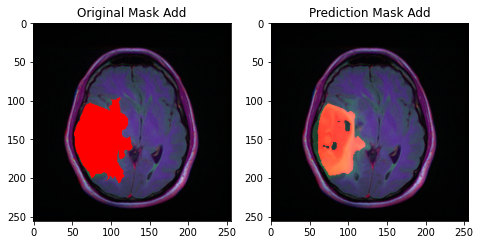

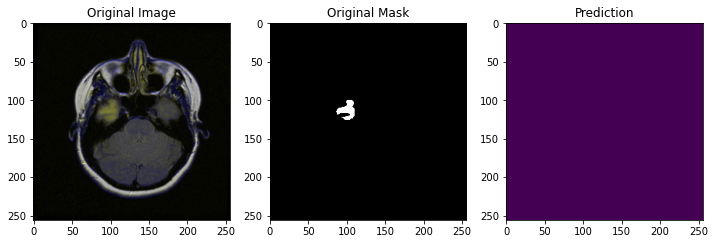

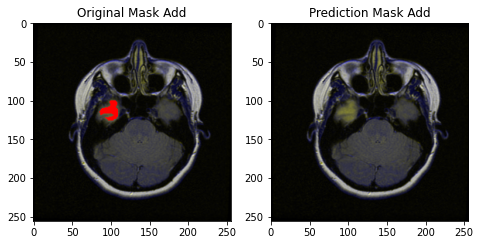

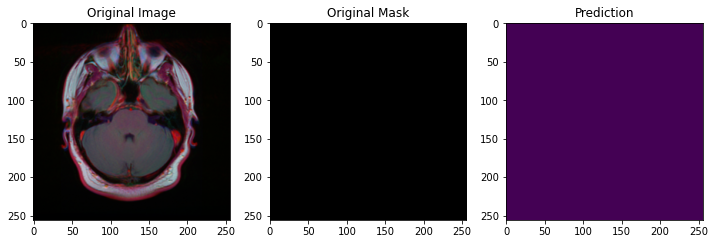

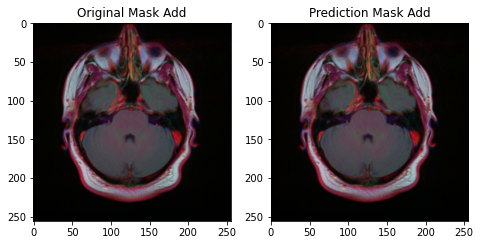

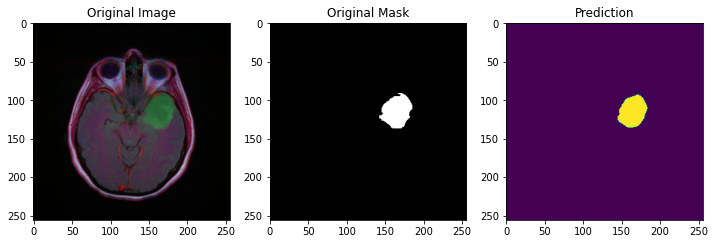

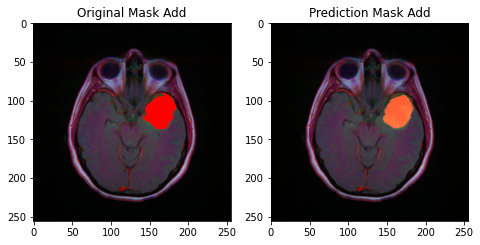

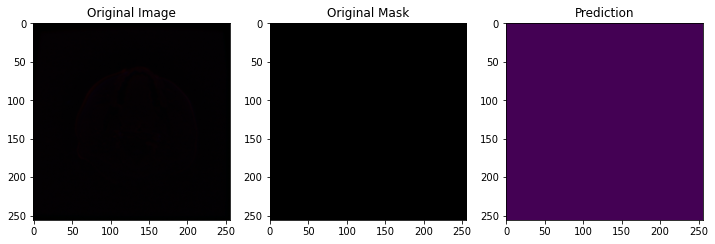

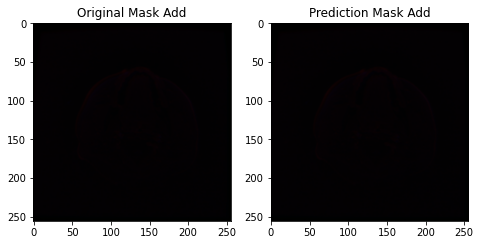

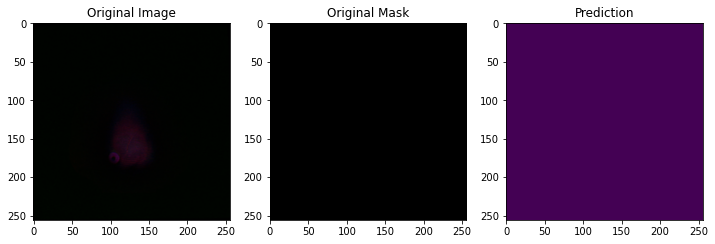

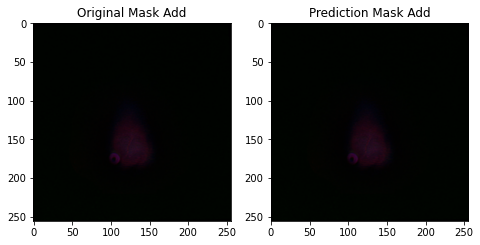

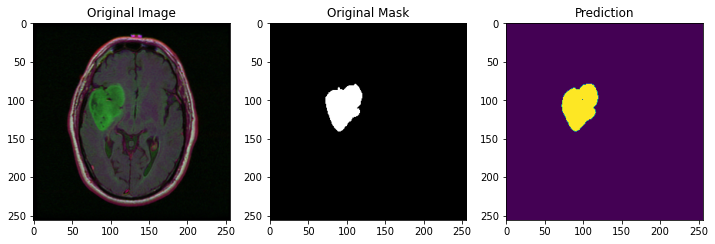

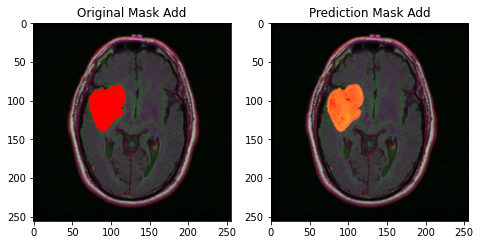

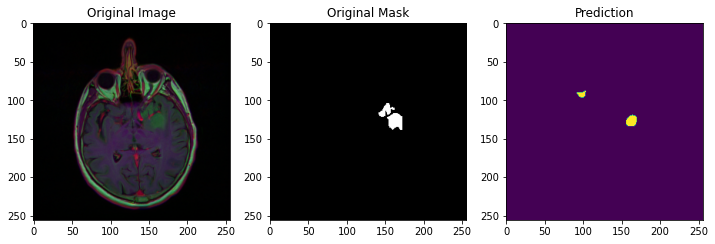

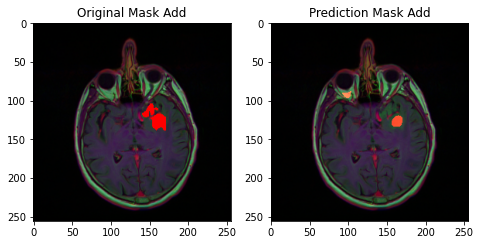

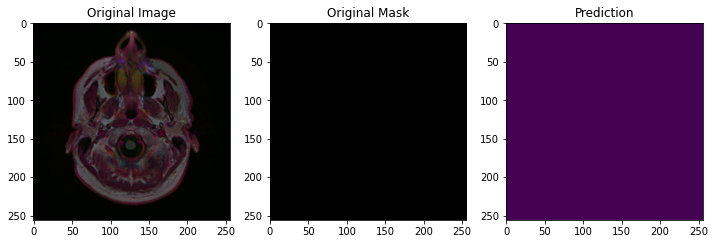

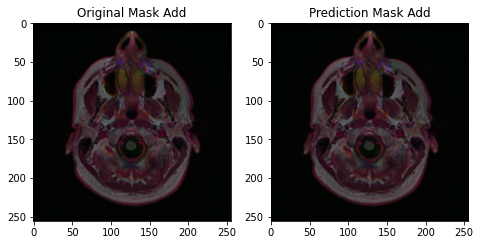

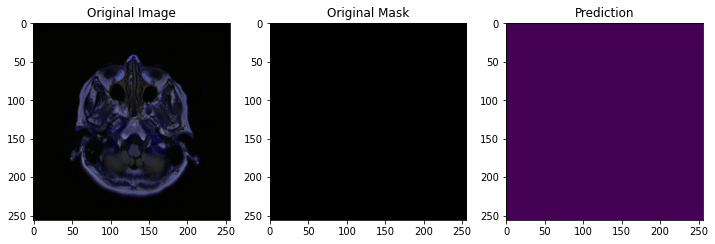

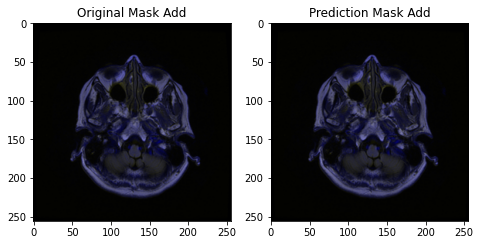

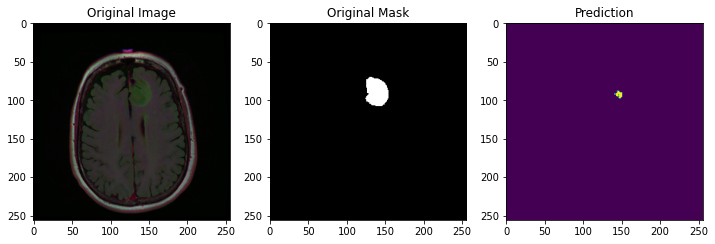

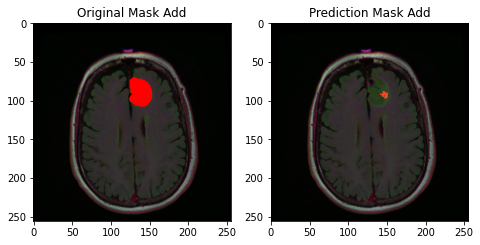

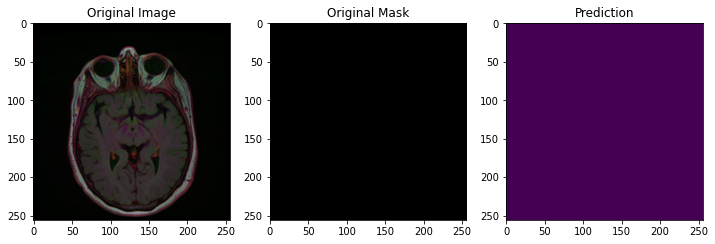

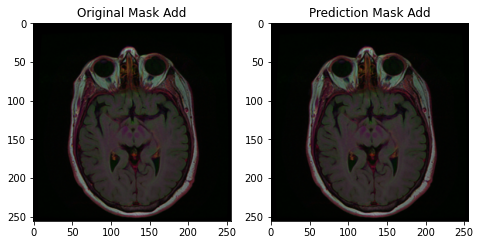

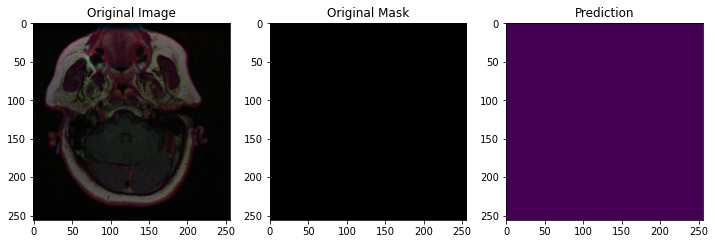

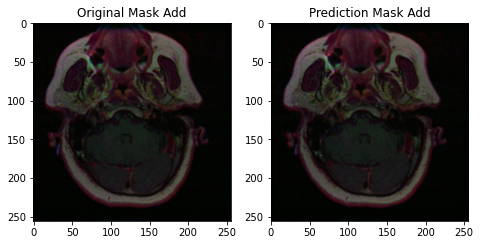

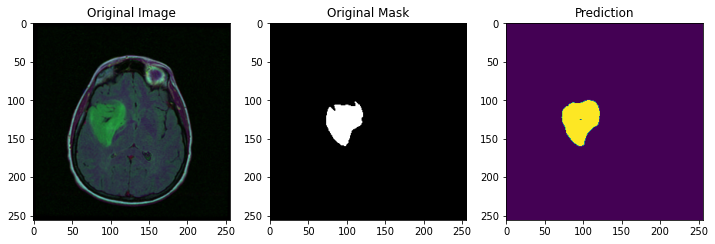

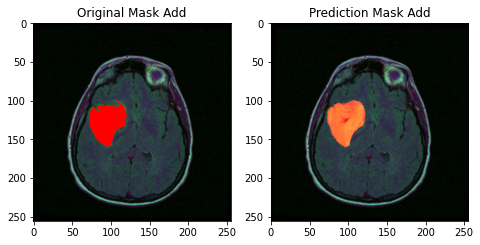

In [ ]:
for i in range(15):
    index=np.random.randint(1,len(df_test.index))
    R_img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(image_height, image_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    msk = cv2.imread(df_test['mask'].iloc[index])
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(msk))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

    img_msk_add = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    for y in range(0,256):
        for x in range(0,256):
            if img_msk_add[y, x] > 10:
                img_msk_add[y, x] = 255
    img_msk_add = cv2.cvtColor(img_msk_add, cv2.COLOR_GRAY2RGB)

    img_msk_add = cv2.add(R_img, img_msk_add)
    img_msk_add[np.where((img_msk_add == [255,255,255]).all(axis = 2))] = [255,0,0]

    plt.figure(figsize=(7.8,7.8))
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(img_msk_add))
    plt.title('Original Mask Add')

    New_img = cv2.cvtColor(R_img, cv2.COLOR_BGR2GRAY)

    New_pred = np.squeeze(pred) > .5

    New_pred = pred.reshape(image_height,image_width, 1)

    New_pred = cv2.cvtColor(New_pred, cv2.COLOR_GRAY2RGB)

    New_pred[np.where((New_pred >= [0.5,0,0]).all(axis = 2))] = [255,0,0]
    New_pred[np.where((New_pred < [0.5,0.5,0.5]).all(axis = 2))] = [0,0,0]
    New_pred = New_pred.astype(np.uint8)

    msk2 = cv2.add(R_img, New_pred)

    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(msk2))
    plt.title('Prediction Mask Add')
    
    plt.show()
    
